## FFT Approach to Fourier Optics Computations

In this notebook: single aperture FFT lens transform example, 4f imaged array field computed from FFT of analytic expression for Fourier plane field

In [3]:
## general imports
from numpy import *
from numpy.fft import fft,fft2,fftshift,ifftshift
from scipy.special import j0, j1
import matplotlib.pyplot as plt
from matplotlib import colors
from time import time
import random as rand

## local imports
from field_funcs import * # my helper functions

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

## scaling FFTs

FFTs aren't fit by default for doing transformations of an optical field by a lens, which can be expressed as a phase mask $exp(-i k \mathbf{\rho_2} \cdot \mathbf{\rho_1}/f)$


Fresnel diffraction:

\begin{equation*}
    A2(\rho_2) = \frac{-i k}{z} e^{i\frac{k}{2 z} \rho_2^2} \mathfrak{F}\big[ A1(\rho_1) e^{i \frac{k}{2 z}\rho_1^2} \big]_{k_{\perp,1}=\frac{k}{z}\rho_2}
\end{equation*}

Transformation by a lens to a distance z2 from the lens, when the object is in the front focal plane:

\begin{equation*}
    A2(\rho_2) = \frac{-i k}{2 \pi f} \mathfrak{F}\big[ A1(\rho_1) e^{ \frac{-i k}{2 f}\rho_1^2(\frac{z_2}{f} - 1)} \big]_{k_{\perp,1}=\frac{k}{f}\rho_2}
\end{equation*}

2D FFT of some array A1:

\begin{equation*}
    A2_{kl} = \sum_{n=0}^{N-1}\sum_{m=0}^{M-1} A1_{nm} \exp \bigg(\frac{-i 2 \pi k n}{N}\bigg) \exp \bigg(\frac{-i 2 \pi l m}{M}\bigg)
\end{equation*}

where in the FT, the exponential in the integrand looks like $exp\big(-i\frac{k}{z}x_1 x_2\big) exp\big(-i\frac{k}{z}y_1 y_2\big) $, $k = 2\pi/ \lambda$. The input field points are separated in real space by $\delta x_1$, and the spacing between field points in the Fourier plane must be proportional to $\delta x_1$. Taking into account that the resolution in the output field must be inversely proportional the number of input pts making up the field, along with the factors in the exponential above, we deduce that the real space separation of points in the Fourier plane is $k z/(\delta x_1 N)$, with the N the number of pts in dimension x. 


## test with circular aperture

In [2]:
## physics and system params
lmbda = 1.064e-6
k = 2*pi/lmbda
f = .1 # 10 cm lens
a = 1e-4
d = 3*a
b = f*3.8317/(a*k)
print(f'b = {b}')

## grid params
w = 3*d # grid half-width
pts = 1001 #1025
x0pts, midpt, xx, yy = get_meshgrid(w, pts)
rr = sqrt(xx**2 + yy**2)
print('rr.shape =', rr.shape)

b = 0.0006488633711537092
rr.shape = (1001, 1001)


In [3]:
mask = circ_mask(rr, a)
mask.shape

(1001, 1001)

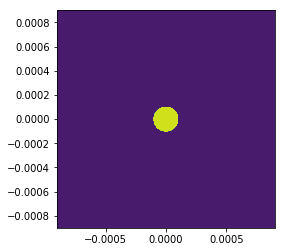

In [68]:
fig, ax = figax()
ax.contourf(x0pts, x0pts, mask)

In [69]:
## compute 2D fft to get the Fourier plane field

padding = int(pts-1/2)
mask = zero_pad(mask, padding)
rr = zero_pad(rr, padding)

field1 = fftshift(fft2(ifftshift(mask)))

field1 = unpad(field1, padding)
mask = unpad(mask, padding)
rr = unpad(rr, padding)

I1 = conjugate(field1)*field1
I1 /= amax(I1)
I1x = justify(I1[midpt,:])

In [70]:
field1.shape, rr.shape, mask.shape

((1001, 1001), (1001, 1001), (1001, 1001))

('b = 0.0006488633711537092', 1001)

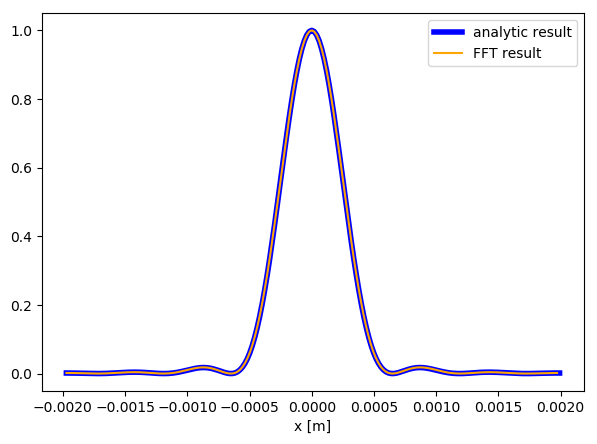

In [71]:
## plot the 1D fft

plt.close()
fig,ax = plt.subplots(figsize=(7,5))
fig.dpi=100

x1pts = array([i*1/(x0pts[1]-x0pts[0])*lmbda*f/(2*padding+pts) for i in linspace(-pts/2, pts/2, pts)])

start = 400
stop = len(x1pts) - start

# plot the analytic result, up to constant scaling factor
I1_func = lambda x: (j1(a*x*k/f)/x)**2
x1_pts = linspace(x1pts[start],x1pts[stop],200) # essentially the same as x1pts but omits x=0
I1_analytic = I1_func(x1_pts)
I1_analytic /= max(I1_analytic)
ax.plot(x1_pts, I1_analytic, label='analytic result', color='blue',linewidth=4)
# ax.set_title('Circular apperture diffraction intensity')

# plot the fft result
ax.plot(x1pts[start:stop], real(I1x)[start:stop], label='FFT result',color='orange')

ax.set_xlabel(r'x [m]')
# ax.set_xlim(-0.002,0.002)

ax.legend(loc='upper right')

# plt.savefig('airy_disk_fft_verification.png', bbox_inches='tight')

f"b = {b}", len(I1x)

In [192]:
x1pts, midpt, rr, pphi = get_meshgrid(x1pts[-1], pts, polar=True)
len(x1pts), x1pts[-1], rr.shape

(1001, 0.009858417564515293, (1001, 1001))

In [193]:
b, rr.shape

(0.0006488633711537092, (1001, 1001))

In [194]:
fourier_mask = circ_mask(rr, b)

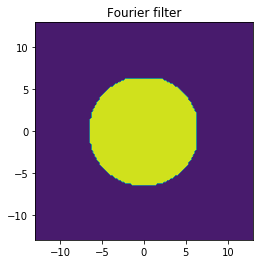

In [197]:
plt.close()
fig,ax = figax(roi=2*b/a)
ax.set_title('Fourier filter')
ax.contourf(x1pts/a,x1pts/a,fourier_mask)

In [22]:
midpt

500

C:\Users\gothr\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


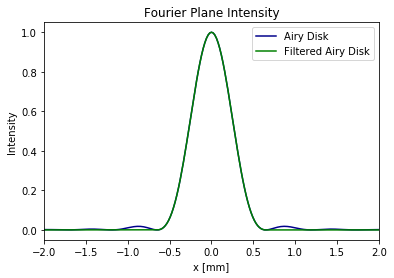

In [75]:
plt.close()
fig,ax = figax(aspect=None, xlabel='x [mm]',ylabel='Intensity')
mmscl = 1e3
ax.plot(x1pts*mmscl, I1[midpt,:], label='Airy Disk', color='darkblue')
ax.plot(x1pts*mmscl, (fourier_mask*I1)[midpt,:], label='Filtered Airy Disk',color='green')
ax.set_xlim(-0.002*mmscl,0.002*mmscl)
ax.set_title('Fourier Plane Intensity')
ax.legend()
# plt.savefig('filtered_airy_disk.png',bbox_inches='tight')

In [114]:
b*1e3

0.6488633711537092

In [76]:
field1.shape, fourier_mask.shape, rr.shape, field1.shape

((1001, 1001), (1001, 1001), (1001, 1001), (1001, 1001))

In [4]:
## filter this field and propagate to output back focal plane

rr = zero_pad(rr, padding)
fourier_mask = zero_pad(fourier_mask, padding)
field1 = zero_pad(field1, padding)

field2 = fftshift(fft2(ifftshift(field1*fourier_mask)))

field1 = unpad(field1, padding)
field2 = unpad(field2, padding)
rr = unpad(rr, padding)

I2 = conjugate(field2)*field2
I2 /= amax(I2)
I2x = justify(I2[midpt,:])

NameError: name 'padding' is not defined

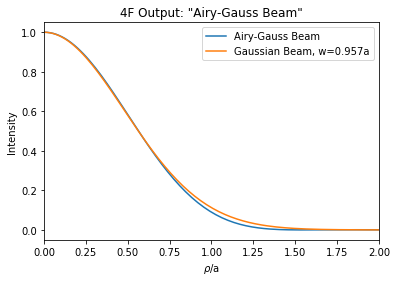

In [80]:
## plot a slice of the output field, an "Airy-Gauss" beam

x2pts = array([i*1/(x1pts[1]-x1pts[0])*lmbda*f/(2*padding+pts) for i in linspace(-pts/2, pts/2, pts)])

gaussian = lambda x, w: exp(-2*x**2/w**2) # intensity profile of a gaussian beam of waist w

plt.close()
fig,ax = figax(aspect=None, xlabel=r'$\rho$/a', ylabel='Intensity')
ax.set_title('4F Output: "Airy-Gauss Beam"')
scl = 1/a
ax.plot(x2pts[midpt:]*scl, real(I2x)[midpt:], label='Airy-Gauss Beam')
w0=.957*a
ax.plot(x2pts[midpt:]*scl, [gaussian(x,w0) for x in x2pts[midpt:]], label=f'Gaussian Beam, w={w0/a:0.3f}a')
ax.set_xlim(0,2*a*scl)
ax.legend(loc='upper right')

# plt.savefig('4f_airy_gauss_beam.png', bbox_inches='tight')

## back propogate the Airy Gauss beam 
make sure to run the above cells. will filtering the airy Gauss beam produce a top hat beam?

In [81]:
## propogate the field through the 4f configuration to get the output field

field0 = field2

padding = int(pts-1/2)
fourier_mask = circ_mask(rr, b)
rr = zero_pad(rr, padding)
field0 = zero_pad(field0, padding)
fourier_mask = zero_pad(fourier_mask, padding)

t0 = time()
field1 = fftshift(fft2(ifftshift(field0)))
x1pts = array([i*1/(x0pts[1]-x0pts[0])*lmbda*f/(2*padding+pts) for i in linspace(-pts/2, pts/2, pts)])
print(f"computed field 1 in {time()-t0} s")

t0 = time()
field2 = fftshift(fft2(ifftshift(field1*fourier_mask)))
x2pts = array([i*1/(x1pts[1]-x1pts[0])*lmbda*f/(2*padding+pts) for i in linspace(-pts/2, pts/2, pts)])
print(f"computed field 2 in {time()-t0} s")

rr = unpad(rr, padding)
field0 = unpad(field0, padding)
field1 = unpad(field1, padding)
field2 = unpad(field2, padding)

I2 = conjugate(field2)*field2
I2 /= amax(I2)
I2x = justify(I2[midpt,:])

computed field 1 in 1.0761549472808838 s
computed field 2 in 1.1987597942352295 s


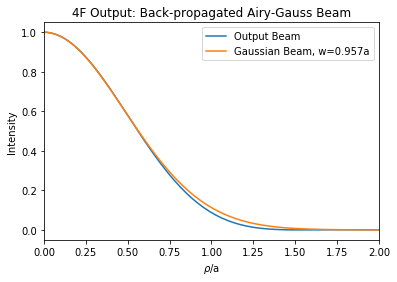

In [89]:
## plot the output field

plt.close()
fig,ax = figax(aspect=None, xlabel=r'$\rho$/a', ylabel='Intensity')
ax.set_title('4F Output: Back-propagated Airy-Gauss Beam')
mmscl = 1/a
ax.plot(x2pts[midpt:]*mmscl, real(I2x)[midpt:], label='Output Beam')

w0 = 0.957*a # fit by eye
gaussian = lambda x, w: exp(-2*x**2/w**2) # intensity profile of a gaussian beam of waist w

ax.plot(x2pts[midpt:]*mmscl, [gaussian(x,w0) for x in x2pts[midpt:]], label=f'Gaussian Beam, w={w0/a:0.3f}a')
ax.set_xlim(0,2*a*mmscl)
ax.legend(loc='upper right')
# plt.savefig('backprop_airy_gauss.png',bbox_inches='tight')

## Reverse operation: Gaussian input
Gaussian * circular aperture --> Airy disk-like --> square wave ish?

In [45]:
## physics and system params
lmbda = 1.064e-6
k = 2*pi/lmbda
f = .1 # 10 cm lens
a = 1e-4
d = 3*a
# b = f*3.8317/(a*k)
# print(f'b = {b}')

## grid params
w = 3*d # grid half-width
pts = 1001 #1025
x0pts, midpt, xx, yy = get_meshgrid(w, pts)
rr = sqrt(xx**2 + yy**2)
print('rr.shape =',rr.shape)

rr.shape = (1001, 1001)


In [46]:
## make a gaussian mask
wg=4*a
gaussian = lambda x: exp(-(x/wg)**2) # field profile of a gaussian beam of waist w0

field0 = gaussian(rr)
I0 = field0*field0


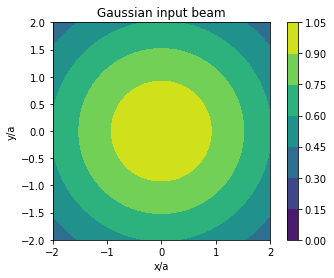

In [35]:
plt.close()
fig,ax = figax(xlabel=r'x/a', ylabel=r'y/a', roi=2)
cax = ax.contourf(x0pts/a, x0pts/a, I0)
ax.set_title('Gaussian input beam')
fig.colorbar(cax)

In [5]:
input_mask = circ_mask(rr, a)

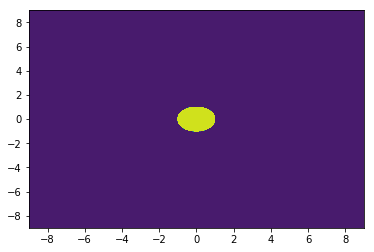

In [37]:
plt.contourf(x0pts/a,x0pts/a, input_mask)

fname = clipped_gaussian_wg4a.png


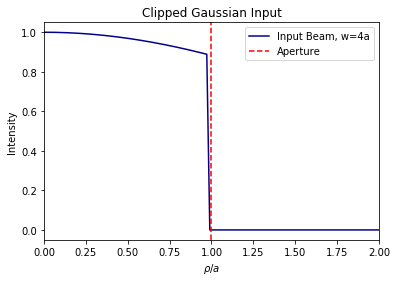

In [47]:
plt.close()
fig,ax = plt.subplots()
# ax.plot(x0pts[midpt:]/a, (I0)[midpt,:][midpt:], label=f'Input Beam, w={wg/a:0.0f}a', color='darkblue')
ax.plot(x0pts[midpt:]/a, (I0*input_mask)[midpt,:][midpt:], label=f'Input Beam, w={wg/a:0.0f}a', color='darkblue')
ax.axvline(x=1, linestyle='--', color='red', label='Aperture') # wg is the radius at 1/e^2 intensity
# ax.axhline(y=1/e**2)
ax.set_xlim(0,2)
ax.set_title('Clipped Gaussian Input')
ax.set_ylabel('Intensity')
ax.set_xlabel(r'$\rho/a$')
ax.legend()
fname = f'clipped_gaussian_wg{int(wg/a)}a.png'
print('fname =',fname)
# plt.savefig(fname, bbox_inches='tight')

In [78]:
1/e**2

0.1353352832366127

In [48]:
## propogate the field through the 4f configuration to get the output field

filter_rad = a 
input_mask = circ_mask(rr, a)

padding = int(pts-1/2)
field0 = zero_pad(field0, padding)
input_mask = zero_pad(input_mask, padding)

t0 = time()
field1 = fftshift(fft2(ifftshift(field0*input_mask)))
x1pts = array([i*1/(x0pts[1]-x0pts[0])*lmbda*f/(2*padding+pts) for i in linspace(-pts/2, pts/2, pts)])
rr = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
# fourier_mask = circ_mask(rr, filter_rad)
# fourier_mask = zero_pad(fourier_mask, padding)

print(f"computed field 1 in {time()-t0} s")

field0 = unpad(field0, padding)
input_mask = unpad(input_mask, padding)
field1 = unpad(field1, padding)

I1 = conjugate(field1)*field1
I1 /= amax(I1)
I1x = justify(I1[midpt,:])

computed field 1 in 0.6113650798797607 s


clipped_gaussian_fourierplane_wg2a.png


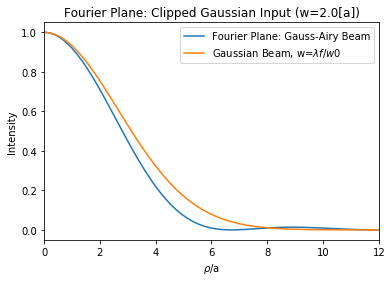

In [23]:
## plot the Fourier plane field

plt.close()
fig,ax = figax(aspect=None, xlabel=r'$\rho$/a', ylabel='Intensity')
ax.set_title(f'Fourier Plane: Clipped Gaussian Input (w={wg/a}[a])')
scl = 1/a
ax.plot(x1pts[midpt:]*scl, real(I1x)[midpt:], label='Fourier Plane: Gauss-Airy Beam')

w0 = lmbda*f/wg
gaussian = lambda x, w: exp(-2*(x/w)**2) # intensity profile of a gaussian beam of waist w
ax.plot(x1pts[midpt:]*scl, [gaussian(x,w0) for x in x1pts[midpt:]], label=r'Gaussian Beam, w=$\lambda f/w0$')

# ax.axvline(x=6.7*a*scl, linestyle='--', color='red', label='filter')
# ax.set_ylim(0,1)

ax.set_xlim(0,12*a*scl)
ax.legend(loc='upper right')
fname = f'clipped_gaussian_fourierplane_wg{int(wg/a)}a.png'
print(fname)
# plt.savefig(fname,bbox_inches='tight')

In [49]:
field1 = zero_pad(field1, padding)

t0 = time()
field2 = fftshift(fft2(ifftshift(field1)))
x2pts = array([i*1/(x1pts[1]-x1pts[0])*lmbda*f/(2*padding+pts) for i in linspace(-pts/2, pts/2, pts)])
print(f"computed field 2 in {time()-t0} s")

field1 = unpad(field1, padding)
field2 = unpad(field2, padding)

I2 = conjugate(field2)*field2

computed field 2 in 0.6781866550445557 s


In [82]:
amax(I2)/(pts**4)

(90.15385702365553+0j)

In [87]:
sum(field0*field0)/(sum(I2)/(pts**4))

(0.10651733134742639+0j)

In [50]:
I2 /= amax(I2)

C:\Users\gothr\Anaconda3\lib\site-packages\numpy\ma\core.py:2788: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


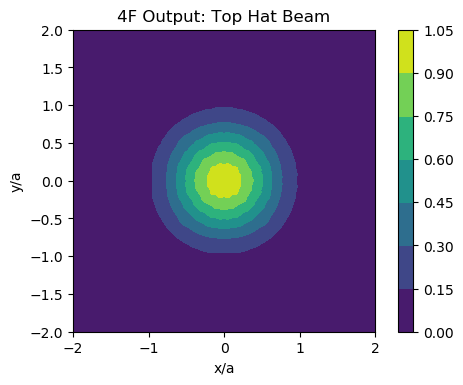

In [12]:
plt.close()
fig,ax = figax(xlabel=r'x/a', ylabel=r'y/a',roi=2)
fig.dpi = 100
cax = ax.contourf(x2pts/a, x2pts/a, I2)
ax.set_title('4F Output: Top Hat Beam')
fig.colorbar(cax)
fname = f'clipped_gaussian_w{int(wg/a)}a_top_hat_output.png'
plt.savefig(fname, bbox_inches='tight')

In [62]:
I2x = justify(I2[midpt,:])

IndexError: index 1001 is out of bounds for axis 0 with size 1001

In [52]:
I2x = I2[midpt,:]

clipped_gaussian_output_wg4a_gcompare.png


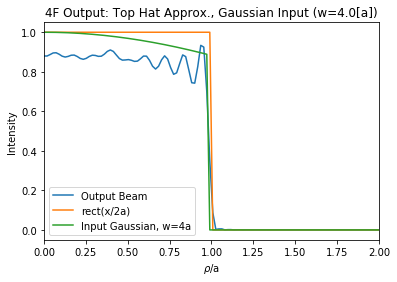

In [56]:
## plot the output field

plt.close()
fig,ax = figax(aspect=None, xlabel=r'$\rho$/a', ylabel='Intensity')
ax.set_title(f'4F Output: Top Hat Approx., Gaussian Input (w={wg/a}[a])')
scl = 1/a
ax.plot(x2pts*scl, real(I2x), label='Output Beam')

rect = lambda x: abs(x) < a 
ax.plot(x2pts*scl, [rect(x) for x in x2pts], label='rect(x/2a)')

ax.plot(x0pts[midpt:]/a, (I0*input_mask)[midpt,:][midpt:], label=f'Input Gaussian, w={wg/a:0.0f}a')#, color='darkblue')

# w0 = 3.5*a # fit by eye
# gaussian = lambda x, w: exp(-2*x**2/w**2) # intensity profile of a gaussian beam of waist w
# ax.plot(x2pts[midpt:]*scl, [gaussian(x,w0) for x in x2pts[midpt:]], label=f'Gaussian Beam, w0={w0/a:0.1f}a')

ax.set_xlim(0,2*a*scl)
# ax.set_ylim(0.5,1.1)
ax.legend(loc='lower left')
fname = f'clipped_gaussian_output_wg{int(wg/a)}a_gcompare.png'
print(fname)
plt.savefig(fname,bbox_inches='tight')

In [50]:
2*b*a*k/f

7.6634

## 4f Imaging with analytic Fourier plane field
Assumes input field with periodic apertures in x and y

In [11]:
## physics and lens params
lmbda = 8.25e-7
k = 2*pi/lmbda
f1 = 1 # lens focal length [m]
f2 = 0.015
A0 = 1 # input field amplitude 

## input mask params
# r = 1/sqrt(1.66) # reflectivity of the spots. if not applicable, just set to 1. trust me.
a = 1e-4
dx = 4.3*a
dy = 1.25*dx
b = f1*3.8317/(a*k)
xnum = ynum = 10

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda 
zTalboty = 2*Ly2**2/lmbda 

## print out parameters
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')

## grid params

w = 4*b # grid half-width
pts = 2000 #1025
x = linspace(-w, w, pts)
y = linspace(-w, w, pts)
x1pts, midpt, xx, yy = get_meshgrid(w, pts)
rr = sqrt(xx**2 + yy**2)

b=0.005031, a=0.0001, dx=0.00043, dy=0.0005375, xnum=10, ynum=10
zTalbotx=0.000101, zTalboty=0.000158


In [12]:
# compute the Fourier plane field with analytic result

def repeat_phase(x1,y1,dx,dy,xnum,ynum,f1,k):
    """
    The sinusoidal factor appearing in the Fourier plane for an input
    field of x (y) periodicity dx (dy)

    x1,y1: spatial coordinate in the Fourier plane
    dx,dy: periodicity in x,y
    f1: focal length of the lens
    """
    return (sin(xnum*k*dx*x1/(2*f1))*sin(ynum*k*dy*y1/(2*f1)) \
            /(sin(sin(k*dx*x1/(2*f1))*sin(k*dy*y1/(2*f1)))))

field1 = zeros((pts, pts))
t0 = time()
q3_phases = empty((midpt, midpt), complex)
q3 = empty((midpt, midpt), complex)
for i in range(midpt):
    for j in range(midpt):
        q3_phases[i,j] = repeat_phase(x1pts[j], x1pts[i], dx, dy, xnum, ynum, f1, k)
        q3[i,j] = -1j*A0*a*j1(a*rr[i,j]*k/f1)*q3_phases[i,j]/rr[i,j]
print(f"calculated in {time()-t0} s")
field1 = from_quadrant3(q3)

calculated in 12.701093912124634 s


In [13]:
I1_xy = conjugate(field1)*field1

# mask the field - pinhole filter of radius b
mask = circ_mask(rr, b)

# fig, ax = figax()
# cbar = ax.contourf(x1pts, x1pts, (I1_xy*mask)[:pts,:pts])
# fig.colorbar(cbar)
# fig.dpi = 100

In [15]:
## compute the 2D fft in xy plane

# make a phase mask for the fft argument -- this propagates the field a distance z2 from lens f2
prop = lambda z2, f2, rr: exp(-1j*k*rr**2*(z2/f2 - 1)/(2*f2)) # = 1 when z2 = f2

# set z2 from second lens
z2 = f2 #- zTalbotx

# pad the field with zeros, as well as any other arrays to be used hereafter.
padding = 100
field1 = zero_pad(field1*mask, padding) # add the mask here too
rr = zero_pad(rr, padding)

t0 = time()
print('f2 - z2 =',f2-z2)
field2 = fftshift(fft2(ifftshift(field1*prop(z2, f2, rr)))) # might need a nyquist mask?
print(f"calculated in {time()-t0} s")

# unpad the fields, etc
field1 = unpad(field1, padding)
field2 = unpad(field2, padding)
rr = unpad(rr, padding)

f2 - z2 = 0.0
calculated in 0.7170822620391846 s


In [16]:
## calculate the output intensity, normalized to intensity in focal plane

# the peak intensity for a bright array may be different based on dx/dy, xnum, ynum, etc
# so anytime you change one of those, run the above cell with z2=f2 to reset the normalization
# constant I2xy_max below before doing subsequent out-of-focus calculations

I2_xy = conjugate(field2)*field2
if f2 - z2 == 0: # will crash if don't run f2-z2 as the first run in the notebook. by design.
    I2xy_max = amax(I2_xy) # so we can always normalize to the focal plane field
    print(f"set the I2xy_max={I2xy_max}")
# I2_xy = 1 - I2_xy/I2xy_max # if dark traps
I2_xy /= I2xy_max

set the I2xy_max=(8324354.683069038+0j)


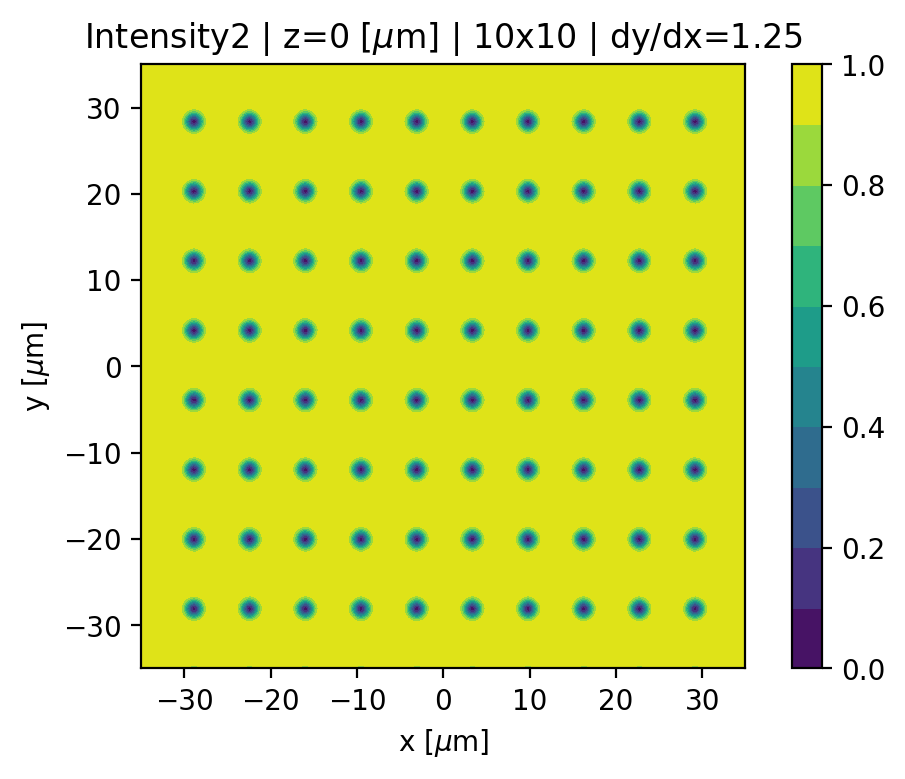

In [19]:
# save file?
savefile=False
fname = f'dark_I2xy_z{(f2 - z2)*1e6:0.0f}um_dydx{int(100*dy/dx)}_{xnum}x{ynum}.png'

x2pts = array([i*1/(x1pts[1]-x1pts[0])*lmbda*f2/(2*padding + pts) for i in linspace(-pts/2, pts/2, pts)])
scl = 1e6
plt.close()
fig,ax = figax(roi=0.000035*scl,xlabel=r'x [$\mu$m]',ylabel=r'y [$\mu$m]')
fig.dpi = 200
if f2 - z2 == 0:
    cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy), levels=linspace(0,1,11))
else:
    cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy))
fig.colorbar(cax, ticks=arange(0,1.2,.2))
cax.set_norm(colors.Normalize(vmin=0, vmax=1))
ax.set_title(rf'Intensity2 | z={(z2 - f2)*1e6:0.0f} [$\mu$m] | {xnum}x{ynum} | dy/dx={dy/dx:0.2f}')
if savefile:
    plt.savefig(fname, bbox_inches='tight')
    print('wrote file to',fname)

## build program to loop over above procedure

In [7]:
## physics and lens params
lmbda = 8.25e-7
k = 2*pi/lmbda
f1 = 1 # lens focal length [m]
f2 = 0.015
A0 = 1 # input field amplitude 

## input mask params
# r = 1/sqrt(1.66) # reflectivity of the spots. if not applicable, just set to 1. trust me.
a = 1e-4
dx = 4.3*a
dy = 0.7*dx
b = f1*3.8317/(a*k)
xnum = ynum = 10

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda 
zTalboty = 2*Ly2**2/lmbda 

## print out parameters
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')

## grid params

w = 4*b # grid half-width
pts = 2000 #1025
x = linspace(-w, w, pts)
y = linspace(-w, w, pts)
x1pts, midpt, xx, yy = get_meshgrid(w, pts)
rr = sqrt(xx**2 + yy**2)

## misc
padding = 100 # pad the field with 100 rows/cols of zeros to increase fft res

b=0.005031, a=0.0001, dx=0.00043, dy=0.000301, xnum=10, ynum=10
zTalbotx=0.000101, zTalboty=0.000049


In [8]:
## bundle the above procedure into functions. 

def get_fourierfield(dx,dy,xnum,ynum,f1,k,a,x1pts,rr,A0=1): 
    """
    the analytic fourier field from a periodic aperture array
    """
    
    def repeat_phase(x1,y1,dx,dy,xnum,ynum,f1,k):
        """
        The sinusoidal factor appearing in the Fourier plane for an input
        field of x (y) periodicity dx (dy)

        x1,y1: spatial coordinate in the Fourier plane
        dx,dy: periodicity in x,y
        f1: focal length of the lens
        """
        return (sin(xnum*k*dx*x1/(2*f1))*sin(ynum*k*dy*y1/(2*f1)) \
                /(sin(sin(k*dx*x1/(2*f1))*sin(k*dy*y1/(2*f1)))))

    pts = len(x1pts)
    midpt = int(pts/2)

    field1 = zeros((pts, pts))
    t0 = time()
    q3_phase = 0 + 0*1j
    q3 = empty((midpt, midpt), complex)
    for i in range(midpt):
        for j in range(midpt):
            q3_phase = repeat_phase(x1pts[j], x1pts[i], dx, dy, xnum, ynum, f1, k)
            q3[i,j] = -1j*A0*a*j1(a*rr[i,j]*k/f1)*q3_phase/rr[i,j]
    print(f"calculated field1 in {time()-t0} s")
    field1 = from_quadrant3(q3)
    
    return field1
    
def get_outputfield(z2,field1,b,f2,k,x1pts,rr,padding):
    """
    the output field calculated with a fft of the input field.
    
    """
    
    I1_xy = conjugate(field1)*field1

    # mask the field - pinhole filter of radius b
    mask = circ_mask(rr, b)
    
    ## compute the 2D fft in xy plane

    # make a phase mask for the fft argument -- this propagates the field a distance z2 from lens f2
    prop = lambda z2, f2, rr: exp(-1j*k*rr**2*(z2/f2 - 1)/(2*f2)) # = 1 when z2 = f2

    # pad the field with zeros, as well as any other arrays to be used hereafter.
    field1 = zero_pad(field1*mask, padding) # add the mask here too
    rr = zero_pad(rr, padding)

    t0 = time()
    print('f2 - z2 =',f2-z2)
    field2 = fftshift(fft2(ifftshift(field1*prop(z2, f2, rr)))) # might need a nyquist mask?
    print(f"calculated field2 in {time()-t0} s")

    # unpad the fields, etc
    field1 = unpad(field1, padding)
    field2 = unpad(field2, padding)
    rr = unpad(rr, padding)
    
    return field2,field1

In [9]:
100*arange(1.18,1.50,0.02)

array([118., 120., 122., 124., 126., 128., 130., 132., 134., 136., 138.,
       140., 142., 144., 146., 148., 150.])

calculated field1 in 23.246835231781006 s
f2 - z2 = 0.0
calculated field2 in 1.1409497261047363 s


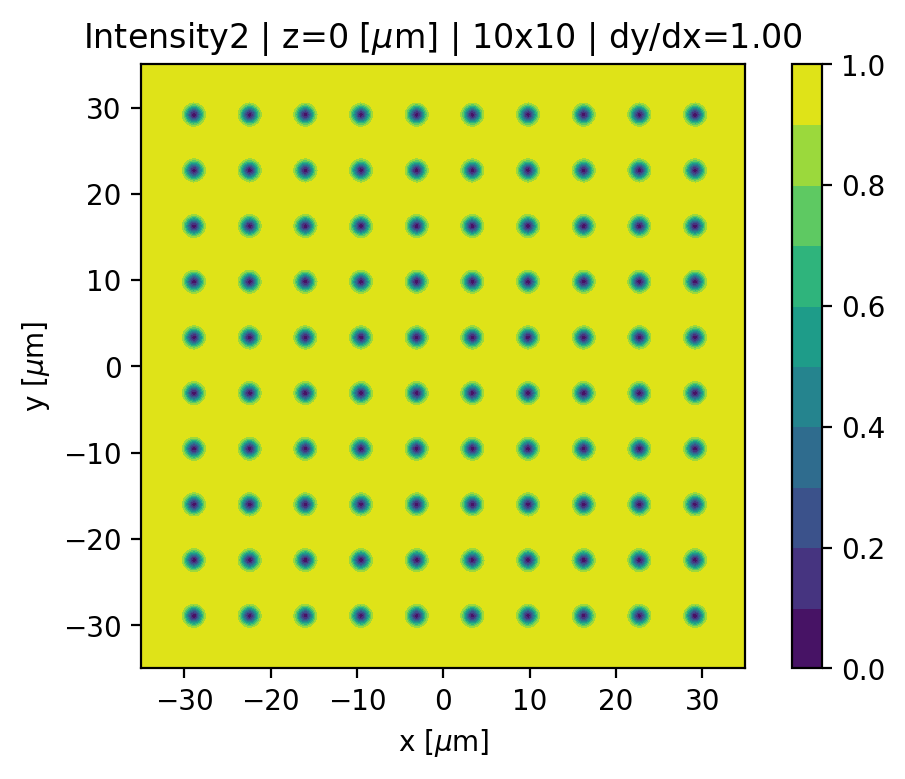

f2 - z2 = 0.0001008545454545453
calculated field2 in 1.3075048923492432 s


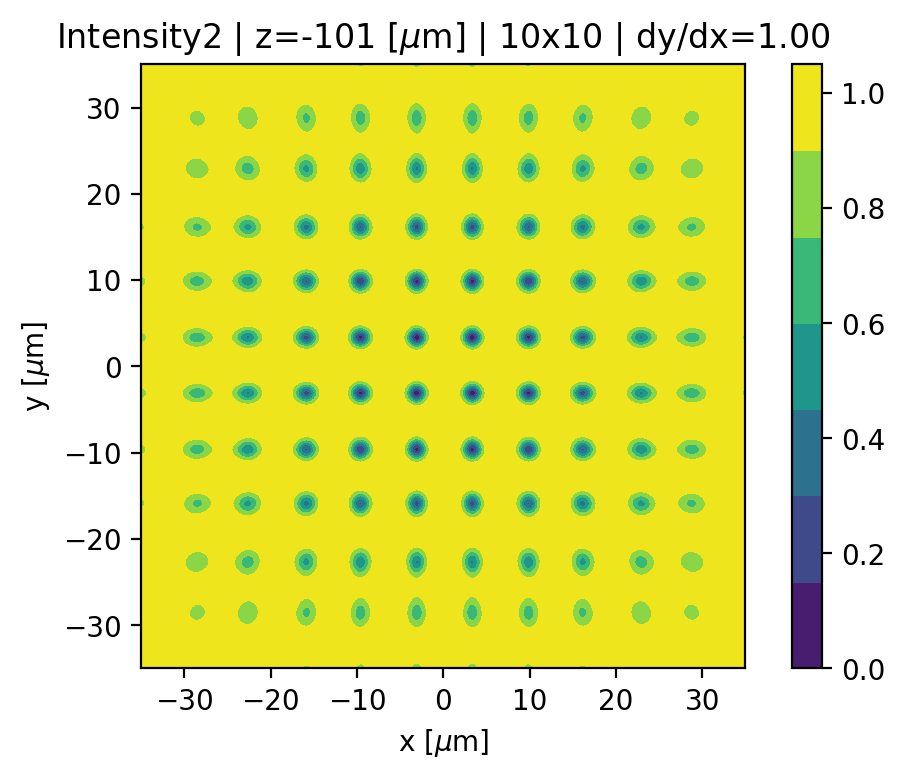

In [10]:
## compute the output field for various values of dy using this packaged prodedure

# save contour plots as pngs?
showcontour=True # must be true in order to save file
savefile=False

# scaled real space pts for output array
x2pts = array([i*1/(x1pts[1]-x1pts[0])*lmbda*f2/(2*padding + pts) for i in linspace(-pts/2, pts/2, pts)])
scl = 1e6

lines = []
labels = []

for alpha in [1.00]: #,1.20,1.22,1.24]:

    dy = alpha*dx

    field1 = get_fourierfield(dx,dy,xnum,ynum,f1,k,a,x1pts,rr,A0=1)

    ## calculate the output intensity, normalized to intensity in focal plane
    # always run with z2 = f2 first
    for z in [0, zTalbotx]:
        z2 = f2 - z
        field2,_ = get_outputfield(z2,field1,b,f2,k,x1pts,rr,padding)

        I2_xy = conjugate(field2)*field2
        if f2 - z2 == 0:
            I2xy_max = amax(I2_xy) 
#             print(f"set the I2xy_max={I2xy_max}")
        I2_xy = 1 - I2_xy/I2xy_max 
    
        fname = f'dark_I2xy_z{(f2 - z2)*1e6:0.0f}um_dydx{int(100*dy/dx)}_{xnum}x{ynum}.png'

        if showcontour:
            fig,ax = figax(roi=0.000035*scl,xlabel=r'x [$\mu$m]',ylabel=r'y [$\mu$m]')
            fig.dpi = 200
#             cbar = ax.contourf(x2pts*scl, x2pts*scl, I2_xy)
#             fig.colorbar(cbar)
            if f2 - z2 == 0:
                cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy), levels=linspace(0,1,11))
            else:
                cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy))
            fig.colorbar(cax, ticks=arange(0,1.2,.2))
            cax.set_norm(colors.Normalize(vmin=0, vmax=1))
            ax.set_title(rf'Intensity2 | z={(z2 - f2)*1e6:0.0f} [$\mu$m] | {xnum}x{ynum} | dy/dx={dy/dx:0.2f}')
            if savefile:
                plt.savefig(fname, bbox_inches='tight')
                print('wrote file to',fname)
                plt.close()
            else:
                plt.show()


    lines.append(I2_xy[:,midpt+11])
    labels.append(f'dy/dx={dy/dx:0.2f}')

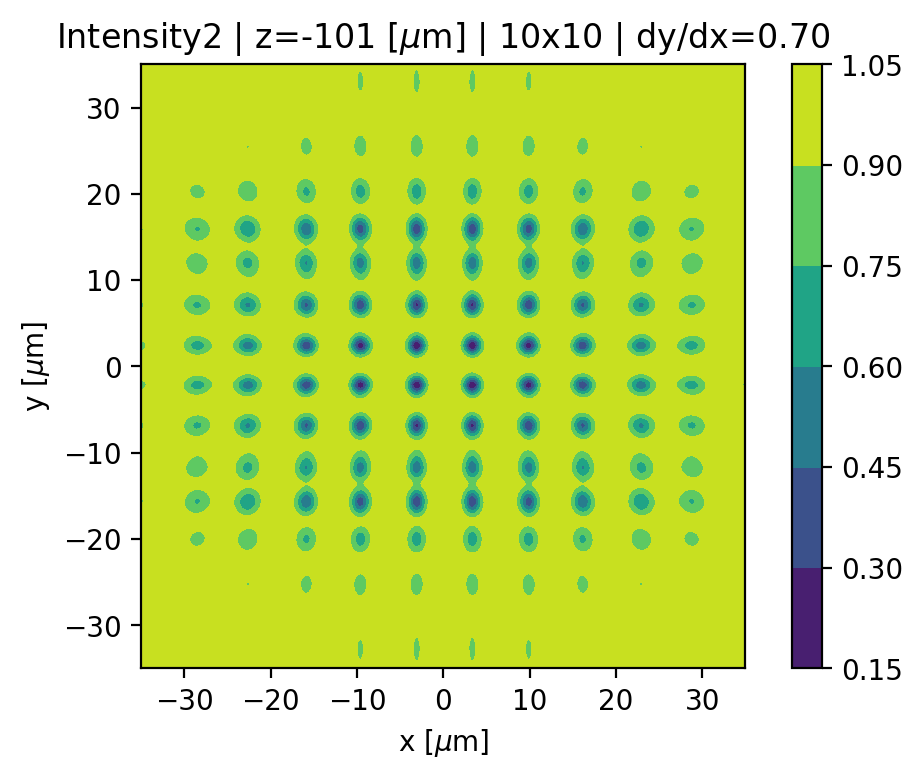

In [14]:
Image('dark_I2xy_z101um_dydx70_10x10.png')

In [13]:
[l for l in labels]

['dy/dx=1.18',
 'dy/dx=1.20',
 'dy/dx=1.22',
 'dy/dx=1.24',
 'dy/dx=1.26',
 'dy/dx=1.28',
 'dy/dx=1.30',
 'dy/dx=1.32',
 'dy/dx=1.34',
 'dy/dx=1.36']

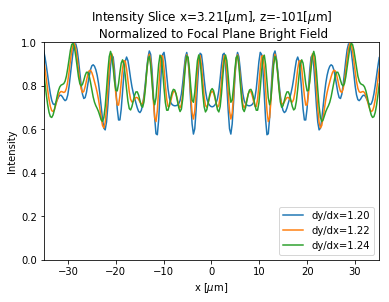

In [19]:
## plot the lines calculated above

savefile = False
fname = f'i2_slice_x{x2pts[midpt-12]*scl:0.2f}um_z{(f2-z2)*scl:0.2f}um_dydx100-124.png'

x2pts = array([i*1/(x1pts[1]-x1pts[0])*lmbda*f2/(2*padding + pts) for i in linspace(-pts/2, pts/2, pts)])
scl = 1e6

fig,ax = figax(roi=0.000035*scl,xlabel=r'x [$\mu$m]',ylabel=r'Intensity',aspect=None)
ax.set_title(rf'Intensity Slice x={x2pts[midpt+11]*scl:0.2f}[$\mu$m], z={(z2-f2)*scl:0.0f}[$\mu$m]'+'\n Normalized to Focal Plane Bright Field')
ax.set_ylim(0,1)
# stop_idx = 7
# for line,label in zip(lines[:stop_idx],labels[:stop_idx]): 
#     ax.plot(x2pts*scl, line, label=label)
for i in [1,2,3]:
    ax.plot(x2pts*scl, lines[i], label=labels[i])
ax.legend(loc='lower right')

if savefile:
    plt.savefig(fname, bbox_inches='tight')
    print('wrote file to',fname)

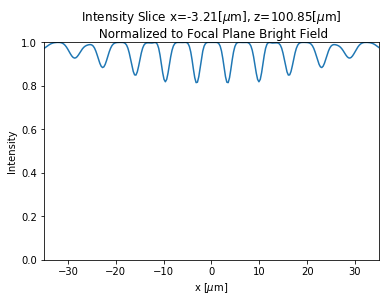

In [34]:
fig,ax = figax(roi=0.000035*scl,xlabel=r'x [$\mu$m]',ylabel=r'Intensity',aspect=None)
ax.set_title(rf'Intensity Slice x={x2pts[midpt-12]*scl:0.2f}[$\mu$m], z={(f2-z2)*scl:0.2f}[$\mu$m]'+'\n Normalized to Focal Plane Bright Field')
ax.set_ylim(0,1) 
for idx in [-1]: # best are 9,10 -- almost equally
    ax.plot(x2pts*scl, lines[idx], label=labels[idx])

Text(0.5, 1.0, 'Intensity2 | z=-101 [$\\mu$m] | 10x10 | dy/dx=1.30')

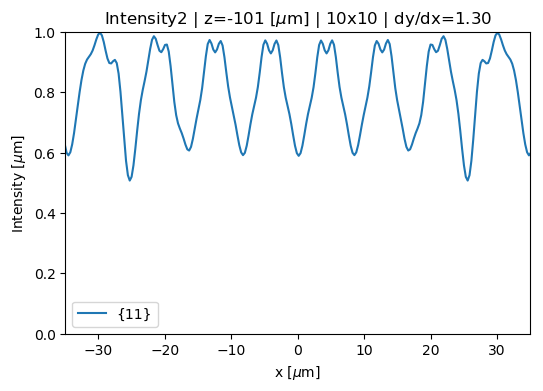

In [47]:
x2pts = array([i*1/(x1pts[1]-x1pts[0])*lmbda*f2/(2*padding + pts) for i in linspace(-pts/2, pts/2, pts)])
scl = 1e6
fig,ax = figax(xlabel=r'x [$\mu$m]',ylabel=r'Intensity [$\mu$m]', aspect=None)
fig.dpi = 100
# cbar = ax.contourf(x2pts*scl, x2pts*scl, I2_xy)
# fig.colorbar(cbar)
# for i in range(9,14):
i=11
ax.plot(x2pts*scl, I2_xy[:,midpt+i], label={i})
ax.legend(loc='lower left')
ax.set_xlim(-0.000035*scl,0.000035*scl)
ax.set_ylim(0,1)
ax.set_title(rf'Intensity2 | z={(z2 - f2)*1e6:0.0f} [$\mu$m] | {xnum}x{ynum} | dy/dx={dy/dx:0.2f}')

In [48]:
x2pts[midpt+11]*scl

3.2143620843839074

(0, 1)

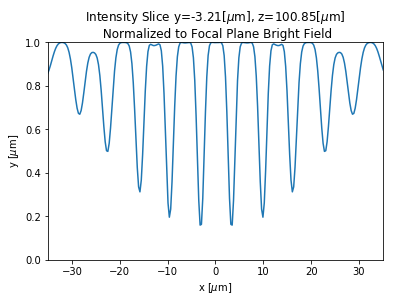

In [260]:
fig,ax = figax(roi=0.000035*scl,xlabel=r'x [$\mu$m]',ylabel=r'y [$\mu$m]',aspect=None)
ax.plot(x2pts*scl, I2_xy[:,midpt+8])
ax.set_title(rf'Intensity Slice y={x2pts[midpt-12]*scl:0.2f}[$\mu$m], z={(f2-z2)*scl:0.2f}[$\mu$m]'+'\n Normalized to Focal Plane Bright Field')
ax.set_ylim(0,1)

## Random Phase Masks
Now use an input field created with random noise-- either in phase or periodicity

In [215]:
## physics and lens params
lmbda = 8.25e-7
k = 2*pi/lmbda
f1 = 1 # lens focal length [m]
f2 = 0.015
A0 = 1 # input field amplitude 

## input mask params
# r = 1/sqrt(1.66) # reflectivity of the spots. if not applicable, just set to 1. trust me.
a = 1e-4
dx = 4.3*a
dy = dx
b = f1*3.8317/(a*k)
xnum = ynum = 10

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda 
zTalboty = 2*Ly2**2/lmbda 

## print out parameters
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')

b=0.005031, a=0.0001, dx=0.00043, dy=0.00043, xnum=10, ynum=10
zTalbotx=0.000101, zTalboty=0.000101


In [217]:
pts = 1000
mask, x1pts = spot_mask(xnum, ynum, a, dx, dy, pts, phi_std=0.1)

(42, 42)


MemoryError: 

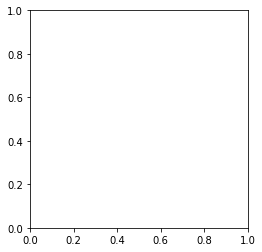

In [220]:
plt.close()
fig,ax = figax()
cbar=ax.contourf(mask)
fig.colorbar(cbar)

In [189]:
f()

0.11945670017876947

In [166]:
mask.shape

(2000, 2000)

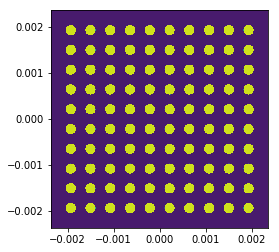

In [177]:
# xpts, ypts = get_grid(dx,dy,xnum,ynum)
# ax.scatter(xpts,ypts)
fig, ax = figax()
ax.contourf(x1pts, x1pts, mask)

In [182]:
random.normal(0,0.1,(2,2))

array([[ 8.69754908e-02, -1.98452181e-01],
       [-6.52582918e-05, -7.61745257e-02]])